In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from mydatools.plot import plot_grid_search_result

% matplotlib inline

In [2]:
train_df = pd.read_csv('./data/input/train.csv')
test_df = pd.read_csv('./data/input/test.csv')
full_df = pd.concat([train_df, test_df], keys=['train', 'test'])
del(train_df)
del(test_df)
full_df.head()

dropoff_datetime  dropoff_latitude  dropoff_longitude         id  \
train 0  2016-03-14 17:32:30         40.765602         -73.964630  id2875421   
      1  2016-06-12 00:54:38         40.731152         -73.999481  id2377394   
      2  2016-01-19 12:10:48         40.710087         -74.005333  id3858529   
      3  2016-04-06 19:39:40         40.706718         -74.012268  id3504673   
      4  2016-03-26 13:38:10         40.782520         -73.972923  id2181028   

         passenger_count      pickup_datetime  pickup_latitude  \
train 0                1  2016-03-14 17:24:55        40.767937   
      1                1  2016-06-12 00:43:35        40.738564   
      2                1  2016-01-19 11:35:24        40.763939   
      3                1  2016-04-06 19:32:31        40.719971   
      4                1  2016-03-26 13:30:55        40.793209   

         pickup_longitude store_and_fwd_flag  trip_duration  vendor_id  
train 0        -73.982155                  N          455.0          2  
      1        -73.980415                  N          663.0          1  
      2        -73.979027                  N         2124.0          2  
      3        -74.010040                  N          429.0          2  
      4        -73.973053                  N          435.0          2

In [3]:
full_df['log1p_trip_duration'] = np.log1p(full_df['trip_duration'])

## feature

In [4]:
feature_columns = [
    'passenger_count', 'vendor_id',
    'store_and_fwd_flag',
    'pickup_latitude', 'pickup_longitude',
    'dropoff_latitude', 'dropoff_longitude', 
]

In [5]:
def add_features(features):
    if type(features) != list:
        features = [features]
    global feature_columns
    feature_columns.extend([f for f in features if f not in feature_columns])

In [6]:
full_df['store_and_fwd_flag'] = full_df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

* generate datetime features

In [7]:
def gen_datetime_feature(prefix):
    # datetime features
    f_datetime = prefix + '_datetime'
    attr_list = [
#         'year', 
        'month', 'day', 'dayofweek', 'dayofyear',
        'hour', 'minute',
    ]

    full_df[f_datetime] = pd.to_datetime(full_df[f_datetime])
    for attr in attr_list:
        full_df[prefix+'_'+attr] = eval("full_df[f_datetime].dt."+attr)
        add_features(prefix+'_'+attr)
    
    full_df[prefix+'_hour_minute'] = full_df[prefix+'_hour'] * 100 + full_df[prefix+'_minute']
    add_features([prefix+'_hour_minute'])

gen_datetime_feature('pickup')
# gen_datetime_feature('dropoff') # 注意 这个不能用 下车时间是结果的一个信息

* riding distance

In [8]:
xy_distance = np.c_[
    (full_df['dropoff_latitude'] - full_df['pickup_latitude']).values,
    (full_df['dropoff_longitude'] - full_df['pickup_longitude']).values,
]
full_df['distance_p2'] = np.linalg.norm(xy_distance, 2, axis=1)
full_df['distance_p1'] = np.linalg.norm(xy_distance, 1, axis=1)
add_features(['distance_p2', 'distance_p1'])

* pos(longitude/latitude) speed

In [9]:
min_longitude, max_longitude = -74.5, -73.5
min_latitude, max_latitude = 40.4, 41.1
    
pos_feats = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

将经纬度分割成一格一格 每一格取速度平均值

In [10]:
# 分割的间隔
pos_interval = 0.01
max_longitude_idx = int((max_longitude - min_longitude) // 0.01)
max_latitude_idx = int((max_latitude - min_latitude) // 0.01)

# 获取每条数据的pos_idx
for posf in pos_feats:
    pos_type = posf.split('_')[1]
    min_v, max_v = eval('min_'+pos_type), eval('max_'+pos_type)
    idx_df = (full_df[posf].clip(min_v, max_v) - min_v) // pos_interval
    idx_df = np.where(idx_df > 0, idx_df, 0) # 没有这个操作会有负数
    full_df['idx_'+posf] = idx_df.astype('int')

In [11]:
# 速度
full_df['speed'] = (full_df['distance_p2'] / full_df['trip_duration'] * 3000).clip(0, 1) # *3000方便查看 没有实际意义
full_df['speed_p1'] = (full_df['distance_p1'] / full_df['trip_duration'] * 3000).clip(0, 1) # *3000方便查看 没有实际意义

In [12]:
# 将df扩充至(0,max_index)和(0,max_columns)
def get_dense_df(df, max_index, max_columns):
    res_df = pd.DataFrame(np.zeros((max_index, max_columns)))
    res_df.iloc[df.index.astype(int), df.columns.astype(int)] = df.values
    return res_df

In [13]:
# 获取上车/下车地点速度（根据train数据）
pickup_speed_dist = full_df.loc['train'].groupby(['idx_pickup_longitude', 'idx_pickup_latitude'])['speed'].mean().unstack()
dropoff_speed_dist = full_df.loc['train'].groupby(['idx_dropoff_longitude', 'idx_dropoff_latitude'])['speed'].mean().unstack()
pickup_speed_dist = get_dense_df(pickup_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values
dropoff_speed_dist = get_dense_df(dropoff_speed_dist.fillna(0), max_longitude_idx+1, max_latitude_idx+1).values

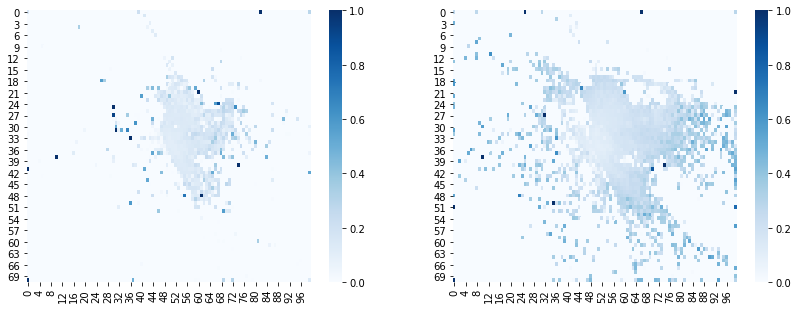

In [14]:
fig, ax = plt.subplots(1,2,figsize=(14,5))

sns.heatmap(pickup_speed_dist.T, cmap=plt.cm.Blues, ax=ax[0])
sns.heatmap(dropoff_speed_dist.T, cmap=plt.cm.Blues, ax=ax[1])

In [15]:
# 根据train的位置速度 计算train/test的位置速度

# 这个方法太慢了
# full_df['pickup_pos_speed'] = full_df.apply(lambda df: pickup_speed_dist.values[df['idx_pickup_longitude'], df['idx_pickup_latitude']], axis=1)

full_df['pickup_pos_speed'] = 0
full_df['dropoff_pos_speed'] = 0

# for i in range(max_longitude_idx+1):
#     pickup_cond1 = (full_df['idx_pickup_longitude'] == i)
#     dropoff_cond1 = (full_df['idx_dropoff_longitude'] == i)

#     for j in range(max_latitude_idx+1):
#         pickup_cond2 = (full_df['idx_pickup_latitude'] == j)
#         dropoff_cond2 = (full_df['idx_dropoff_latitude'] == j)
        
#         full_df.loc[pickup_cond1 & pickup_cond2, 'pickup_pos_speed'] = pickup_speed_dist[i][j]
#         full_df.loc[dropoff_cond1 & dropoff_cond2, 'dropoff_pos_speed'] = dropoff_speed_dist[i][j]
        
# full_df[['pickup_pos_speed', 'dropoff_pos_speed']].to_csv('./data/input/tmp_pos_speed.csv', index=False)

full_df[['pickup_pos_speed', 'dropoff_pos_speed']] = pd.read_csv('./data/input/tmp_pos_speed.csv').values

add_features(['pickup_pos_speed', 'dropoff_pos_speed'])

In [16]:
# 计算起点到终点范围内的速度

full_df['range_speed_by_pickup_speed'] = 0
full_df['range_speed_by_dropoff_speed'] = 0

# # 计算哪些位置是非0的
# pickup_speed_dist_isnotnan = np.where(pickup_speed_dist == 0, 0, 1)
# dropoff_speed_dist_isnotnan = np.where(dropoff_speed_dist == 0, 0, 1)

# full_df['min_idx_longitude'] = full_df[['idx_pickup_longitude', 'idx_dropoff_longitude']].min(axis=1)
# full_df['max_idx_longitude'] = full_df[['idx_pickup_longitude', 'idx_dropoff_longitude']].max(axis=1)
# full_df['min_idx_latitude'] = full_df[['idx_pickup_latitude', 'idx_dropoff_latitude']].min(axis=1)
# full_df['max_idx_latitude'] = full_df[['idx_pickup_latitude', 'idx_dropoff_latitude']].max(axis=1)

# full_df['range_speed_by_pickup_speed'] = full_df.apply(
#     lambda df: 
#         pickup_speed_dist[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum() / 
#         pickup_speed_dist_isnotnan[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum(),
#     axis=1).fillna(0)

# full_df['range_speed_by_dropoff_speed'] = full_df.apply(
#     lambda df: 
#         dropoff_speed_dist[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum() / 
#         dropoff_speed_dist_isnotnan[
#             df['min_idx_longitude']: df['max_idx_longitude'] + 1,
#             df['min_idx_latitude']: df['max_idx_latitude'] + 1,
#         ].sum(),
#     axis=1).fillna(0)

# full_df[['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed']].to_csv('./data/input/tmp_range_speed.csv', index=False)

full_df[['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed']] = pd.read_csv('./data/input/tmp_range_speed.csv').values

add_features(['range_speed_by_pickup_speed', 'range_speed_by_dropoff_speed'])

## EDA

In [17]:
tdf = full_df.copy()

tdf = tdf[tdf['trip_duration'] < 500000]
tdf = tdf[tdf['pickup_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['pickup_latitude'].between(min_latitude, max_latitude)]
tdf = tdf[tdf['dropoff_longitude'].between(min_longitude, max_longitude)]
tdf = tdf[tdf['dropoff_latitude'].between(min_latitude, max_latitude)]

* 上车/下车地点分布

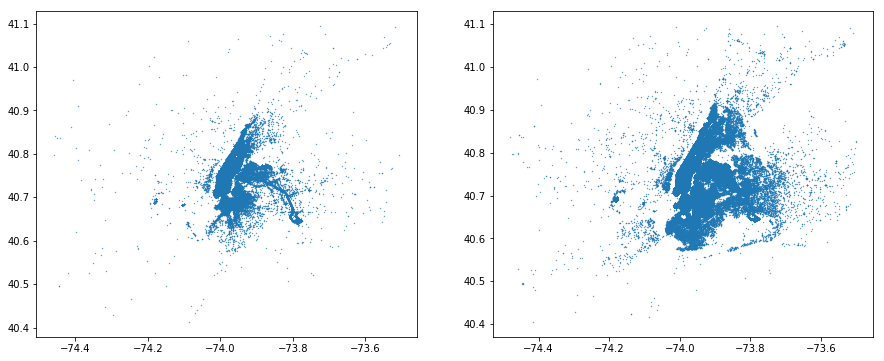

In [18]:
plt.subplots(1, 2, figsize=(15,6))

plt.subplot(121)
plt.scatter(tdf['pickup_longitude'], tdf['pickup_latitude'], s=0.1)

plt.subplot(122)
plt.scatter(tdf['dropoff_longitude'], tdf['dropoff_latitude'], s=0.1)

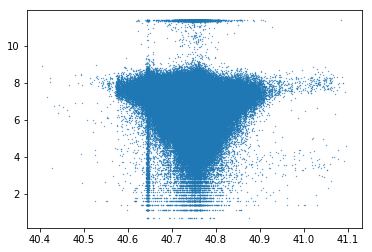

In [19]:
# plt.scatter(tdf['distance'], tdf['log1p_trip_duration'], s=0.1) # 这个有明显的关系
plt.scatter(tdf['dropoff_latitude'], tdf['log1p_trip_duration'], s=0.1)

* 可以看到 不同的位置 行驶的速度还是有区别的 

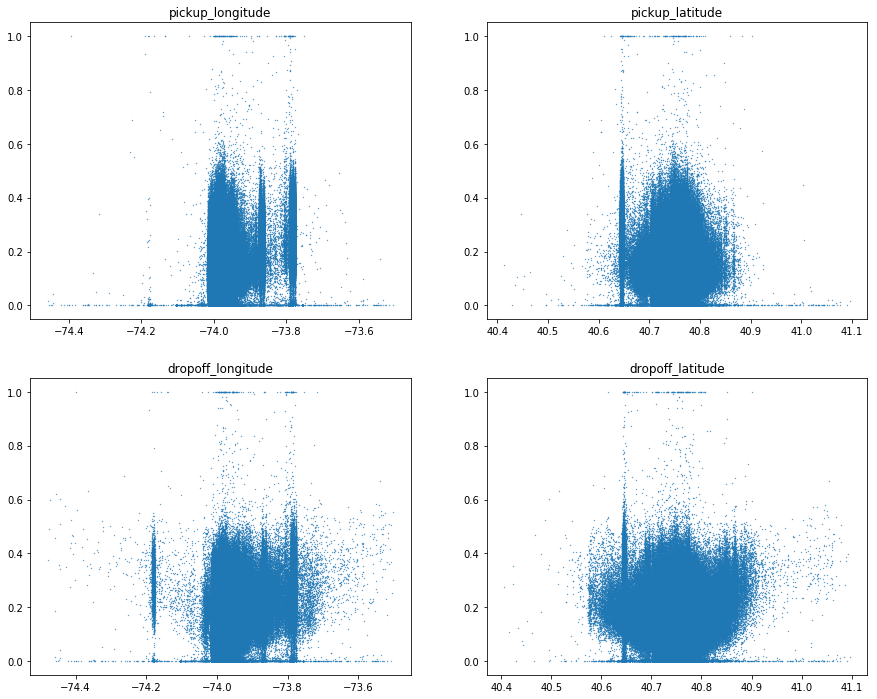

In [20]:
def show_pos(df, f):
    plt.subplots(2, 2, figsize=(15,12))
 
    for i, posf in enumerate(pos_feats):
        plt.subplot(2,2,i+1)
        plt.scatter(tdf[posf], tdf[f], s=0.1)
        plt.title(posf)
        
show_pos(tdf, 'speed')

* 速度跟周几还是很有关系的

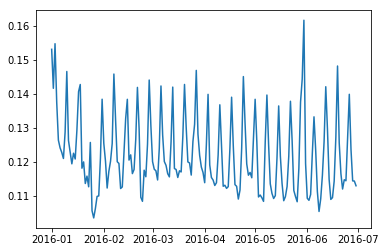

In [21]:
plt.plot(tdf.groupby(tdf['pickup_datetime'].dt.date)['speed'].mean())

## 相关性

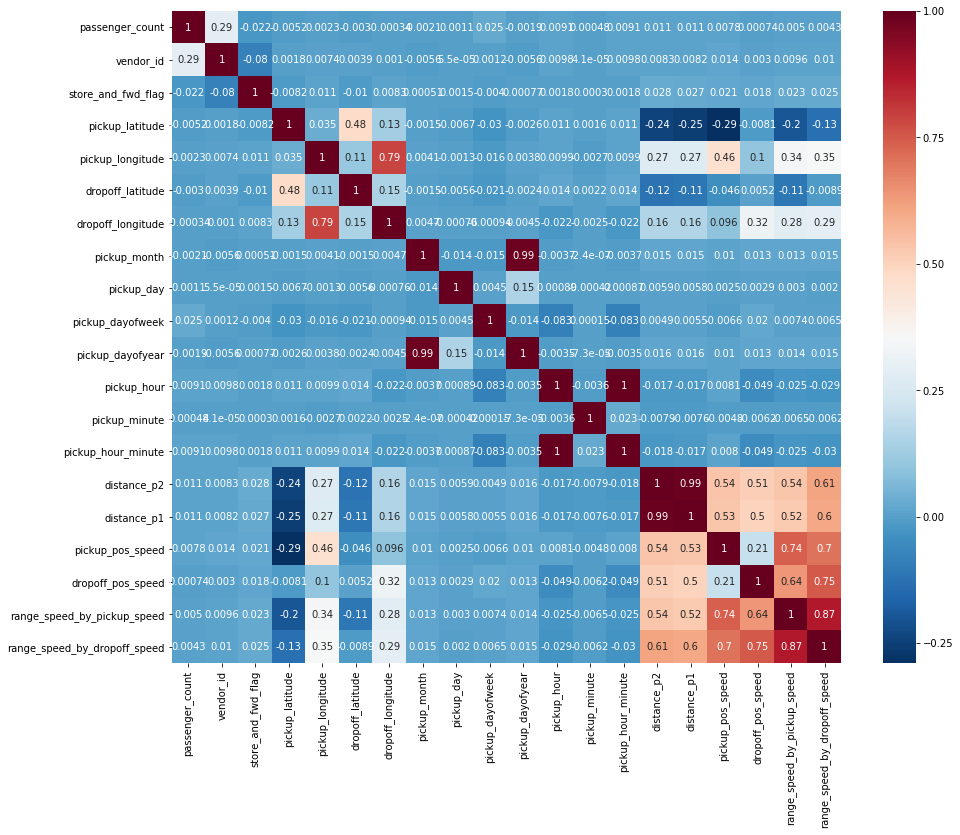

In [32]:
fig, ax = plt.subplots(1,1,figsize=(15,12))
corr_df = full_df[feature_columns].corr()
sns.heatmap(corr_df, annot=True, cmap=plt.cm.RdBu_r)

## 预处理

In [22]:
trn_df = full_df.loc['train']
tst_df = full_df.loc['test']

X = trn_df[feature_columns].values
y = trn_df['log1p_trip_duration'].values
X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

X_tst = tst_df[feature_columns].values
# y_tst = tst_df['log1p_trip_duration'].values

trn_lgb = lgb.Dataset(X_trn, y_trn, free_raw_data=False)
val_lgb = lgb.Dataset(X_val, y_val, free_raw_data=False, reference=trn_lgb)

## LightGBM

In [23]:
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.2,
#     'max_depth': 5,
#     'num_leaves': 20,
#     'subsample': 0.8,
#     'colsample_bytree': 0.5,
#     'min_child_weight': 3, 
#     'min_child_samples': 6,
#     'reg_alpha': 0.01,
    'verbose': 1,
    'seed': 0,
}
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20)
bst.save_model('./data/output/model.txt')

[1]	training's rmse: 0.699097	valid_1's rmse: 0.697027
Train until valid scores didn't improve in 20 rounds.
[2]	training's rmse: 0.627673	valid_1's rmse: 0.625676
[3]	training's rmse: 0.576102	valid_1's rmse: 0.574193
[4]	training's rmse: 0.539079	valid_1's rmse: 0.537188
[5]	training's rmse: 0.513354	valid_1's rmse: 0.511593
[6]	training's rmse: 0.493712	valid_1's rmse: 0.492023
[7]	training's rmse: 0.48038	valid_1's rmse: 0.478723
[8]	training's rmse: 0.470473	valid_1's rmse: 0.468862
[9]	training's rmse: 0.462847	valid_1's rmse: 0.461343
[10]	training's rmse: 0.457679	valid_1's rmse: 0.456173
[11]	training's rmse: 0.453239	valid_1's rmse: 0.451813
[12]	training's rmse: 0.450151	valid_1's rmse: 0.448708
[13]	training's rmse: 0.447577	valid_1's rmse: 0.446138
[14]	training's rmse: 0.445446	valid_1's rmse: 0.444044
[15]	training's rmse: 0.443737	valid_1's rmse: 0.442349
[16]	training's rmse: 0.442201	valid_1's rmse: 0.44084
[17]	training's rmse: 0.440557	valid_1's rmse: 0.439232
[18]	

[148]	training's rmse: 0.403384	valid_1's rmse: 0.40905
[149]	training's rmse: 0.403239	valid_1's rmse: 0.408922
[150]	training's rmse: 0.403059	valid_1's rmse: 0.408751
[151]	training's rmse: 0.402917	valid_1's rmse: 0.40863
[152]	training's rmse: 0.402831	valid_1's rmse: 0.408598
[153]	training's rmse: 0.402704	valid_1's rmse: 0.408562
[154]	training's rmse: 0.402616	valid_1's rmse: 0.408507
[155]	training's rmse: 0.402546	valid_1's rmse: 0.408466
[156]	training's rmse: 0.402468	valid_1's rmse: 0.408446
[157]	training's rmse: 0.402429	valid_1's rmse: 0.408436
[158]	training's rmse: 0.402296	valid_1's rmse: 0.408387
[159]	training's rmse: 0.402208	valid_1's rmse: 0.408311
[160]	training's rmse: 0.402107	valid_1's rmse: 0.408248
[161]	training's rmse: 0.40205	valid_1's rmse: 0.408237
[162]	training's rmse: 0.401916	valid_1's rmse: 0.408157
[163]	training's rmse: 0.401808	valid_1's rmse: 0.408068
[164]	training's rmse: 0.401666	valid_1's rmse: 0.407962
[165]	training's rmse: 0.401552	va

[296]	training's rmse: 0.391326	valid_1's rmse: 0.403622
[297]	training's rmse: 0.391259	valid_1's rmse: 0.403571
[298]	training's rmse: 0.391237	valid_1's rmse: 0.403577
[299]	training's rmse: 0.39119	valid_1's rmse: 0.403573
[300]	training's rmse: 0.391122	valid_1's rmse: 0.403565
[301]	training's rmse: 0.391074	valid_1's rmse: 0.403548
[302]	training's rmse: 0.39103	valid_1's rmse: 0.403511
[303]	training's rmse: 0.390986	valid_1's rmse: 0.403498
[304]	training's rmse: 0.390958	valid_1's rmse: 0.403492
[305]	training's rmse: 0.390895	valid_1's rmse: 0.403514
[306]	training's rmse: 0.390833	valid_1's rmse: 0.403466
[307]	training's rmse: 0.390806	valid_1's rmse: 0.403465
[308]	training's rmse: 0.390758	valid_1's rmse: 0.403435
[309]	training's rmse: 0.390677	valid_1's rmse: 0.403421
[310]	training's rmse: 0.390627	valid_1's rmse: 0.403405
[311]	training's rmse: 0.390552	valid_1's rmse: 0.403359
[312]	training's rmse: 0.390519	valid_1's rmse: 0.403337
[313]	training's rmse: 0.390473	v

[443]	training's rmse: 0.383879	valid_1's rmse: 0.401761
[444]	training's rmse: 0.383836	valid_1's rmse: 0.401732
[445]	training's rmse: 0.383796	valid_1's rmse: 0.401724
[446]	training's rmse: 0.383723	valid_1's rmse: 0.401723
[447]	training's rmse: 0.383687	valid_1's rmse: 0.401717
[448]	training's rmse: 0.383679	valid_1's rmse: 0.401712
[449]	training's rmse: 0.383644	valid_1's rmse: 0.401704
[450]	training's rmse: 0.3836	valid_1's rmse: 0.401685
[451]	training's rmse: 0.38354	valid_1's rmse: 0.40165
[452]	training's rmse: 0.38348	valid_1's rmse: 0.401621
[453]	training's rmse: 0.383401	valid_1's rmse: 0.401637
[454]	training's rmse: 0.383361	valid_1's rmse: 0.401613
[455]	training's rmse: 0.3833	valid_1's rmse: 0.401596
[456]	training's rmse: 0.383239	valid_1's rmse: 0.401571
[457]	training's rmse: 0.383198	valid_1's rmse: 0.401545
[458]	training's rmse: 0.383151	valid_1's rmse: 0.401536
[459]	training's rmse: 0.383091	valid_1's rmse: 0.401541
[460]	training's rmse: 0.382991	valid_

[591]	training's rmse: 0.377561	valid_1's rmse: 0.400152
[592]	training's rmse: 0.377514	valid_1's rmse: 0.400158
[593]	training's rmse: 0.377494	valid_1's rmse: 0.400162
[594]	training's rmse: 0.377458	valid_1's rmse: 0.400147
[595]	training's rmse: 0.377428	valid_1's rmse: 0.40015
[596]	training's rmse: 0.377398	valid_1's rmse: 0.400144
[597]	training's rmse: 0.37737	valid_1's rmse: 0.400135
[598]	training's rmse: 0.377322	valid_1's rmse: 0.400144
[599]	training's rmse: 0.377272	valid_1's rmse: 0.400141
[600]	training's rmse: 0.377241	valid_1's rmse: 0.400128
[601]	training's rmse: 0.37722	valid_1's rmse: 0.400116
[602]	training's rmse: 0.377178	valid_1's rmse: 0.400124
[603]	training's rmse: 0.377136	valid_1's rmse: 0.400104
[604]	training's rmse: 0.37708	valid_1's rmse: 0.400099
[605]	training's rmse: 0.377047	valid_1's rmse: 0.40008
[606]	training's rmse: 0.376978	valid_1's rmse: 0.400086
[607]	training's rmse: 0.376934	valid_1's rmse: 0.400055
[608]	training's rmse: 0.3769	valid_

In [24]:
bst = lgb.train(params, trn_lgb, 1000, valid_sets=[trn_lgb, val_lgb], early_stopping_rounds=20,
                init_model='./data/output/model.txt', 
                learning_rates=lambda iter: 0.2 * (0.99 ** iter))

[668]	training's rmse: 0.374779	valid_1's rmse: 0.39961
Train until valid scores didn't improve in 20 rounds.
[669]	training's rmse: 0.374718	valid_1's rmse: 0.399637
[670]	training's rmse: 0.374683	valid_1's rmse: 0.399639
[671]	training's rmse: 0.374641	valid_1's rmse: 0.399654
[672]	training's rmse: 0.374612	valid_1's rmse: 0.399637
[673]	training's rmse: 0.374559	valid_1's rmse: 0.39964
[674]	training's rmse: 0.374492	valid_1's rmse: 0.399637
[675]	training's rmse: 0.374436	valid_1's rmse: 0.399633
[676]	training's rmse: 0.374421	valid_1's rmse: 0.399626
[677]	training's rmse: 0.374369	valid_1's rmse: 0.399646
[678]	training's rmse: 0.374339	valid_1's rmse: 0.399644
[679]	training's rmse: 0.374317	valid_1's rmse: 0.399637
[680]	training's rmse: 0.37428	valid_1's rmse: 0.399621
[681]	training's rmse: 0.374243	valid_1's rmse: 0.399619
[682]	training's rmse: 0.374211	valid_1's rmse: 0.399639
[683]	training's rmse: 0.374195	valid_1's rmse: 0.399648
[684]	training's rmse: 0.374173	valid

In [25]:
imp_df = pd.DataFrame([bst.feature_importance()], columns=feature_columns, index=['importance']).T.sort_values(by='importance', ascending=False)
imp_df

,importance
distance_p2,2155
pickup_latitude,1966
pickup_hour_minute,1890
dropoff_latitude,1886
distance_p1,1423
dropoff_pos_speed,1419
pickup_pos_speed,1324
range_speed_by_pickup_speed,1297
range_speed_by_dropoff_speed,1258
pickup_dayofyear,1253


## predict

In [26]:
pred_log1p = bst.predict(X_tst)
pred_res = np.expm1(pred_log1p)

In [27]:
res_df = pd.DataFrame({
    'id': tst_df['id'],
    'trip_duration': pred_res,
})
res_df.to_csv('./data/output/submission.csv', index=False)